Привет! Хотел бы поблагодарить за возможность выполнить тестовое задание и проявить себя :) Это было очень увлекательно, надеюсь, что вам понравится!

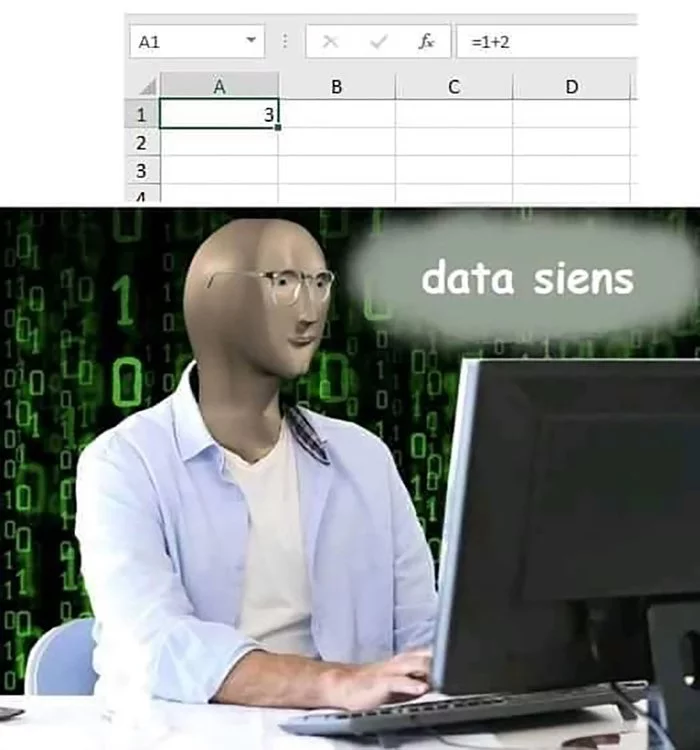

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import randint
import shap

random.seed(42)
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Анализ и предобработка данных

Загрузил данные и дропнул лишний столбец с индексами

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/cs-training.csv")
train_df.drop('Unnamed: 0',axis=1,inplace=True)
train_df.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


Посмотрим описательную статистику для каждой фичи.Минимальное значение возраста - 0 очевидный выброс , максимальный возраст - 109 тоже вызывает вопросы.Cредний возраст по всему датасету - 52 , данные смещены по возрасту ближе к пенсеонному возрасту . NumberOfTimes90DaysLate , NumberRealEstateLoansOrLines,NumberOfDependents -  крайне разреженные , средние значения близки к 0.

In [4]:
train_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Обработаем пропуски:заполним пропущенные значения медианами фичей. Взял медиану т.к. она является робастной величиной.

In [5]:
train_df.isna().sum()

,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,29731
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0


Обработаю  датасет

In [7]:
imp_median = SimpleImputer( strategy='median')
s = imp_median.fit(train_df[['MonthlyIncome']])
train_df['MonthlyIncome'] = s.transform(train_df[['MonthlyIncome']])

In [8]:
imp_mean = SimpleImputer( strategy='median')
s2 = imp_median.fit(train_df[['NumberOfDependents']])
train_df['NumberOfDependents'] = s2.transform(train_df[['NumberOfDependents']])

Пропусков не осталось ✅

In [9]:
train_df.isna().sum()

,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,0
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0


Посмотрим есть ли дубликаты и удалим их при наличии

In [11]:
train_df.duplicated().sum()

np.int64(767)

In [12]:
train_df.drop_duplicates(inplace=True)

In [13]:
train_df.duplicated().sum()

np.int64(0)

Посмотрю распределения основных фичей. Думаю что наиболее важными являются - возраст , месячный доход , колличество открытых кредитов и долговая нагрузка.
Очевидно , что кредитоспособность возрастной группы <30 лет в среднем будет ниже людей старше 30. Если у человека низкий месячный доход и при этом высокая долговая нагрузка , то вероянтость того , что он закроет кредит вовремя <<< вероятности закрытия кредита  человеком с более высоким доходом и меньшей долговой нагрузкой. Высокое колличество открытых кредитов говорит о безответственном отношении к долговым обязательством и как следствие о высокой вероятности дефолта.

Много выбросов связаны с слишком высоким возрастом . Хотелось бы видеть меньшее смещённе по возрасту данные: с медианой ~40 лет

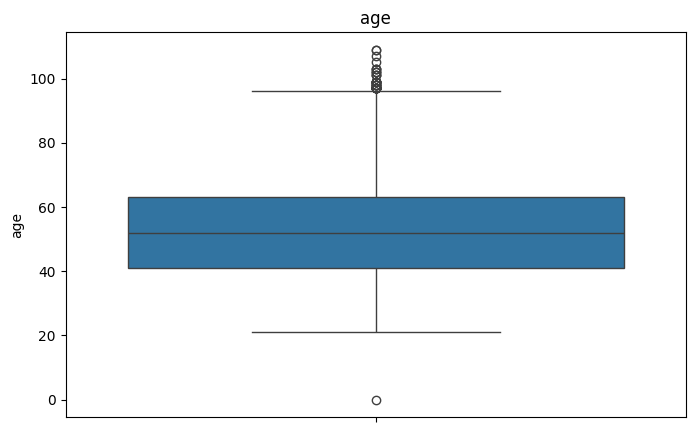

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['age'])

plt.title('age')

plt.show()

Не думаю что людям выдают больше 20 кредитов...

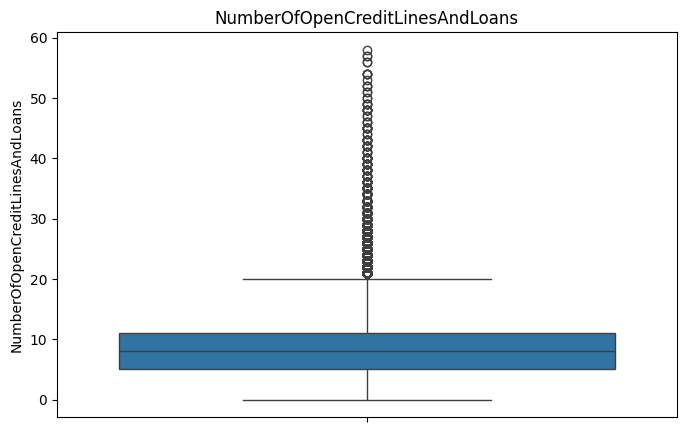

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['NumberOfOpenCreditLinesAndLoans'])

plt.title('NumberOfOpenCreditLinesAndLoans')

plt.show()

В месячном доходе и долговой нагрузке очень много выбросов

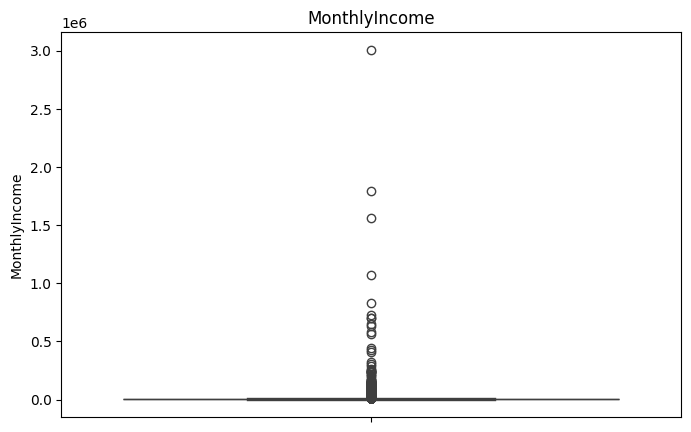

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['MonthlyIncome'])

plt.title('MonthlyIncome')

plt.show()

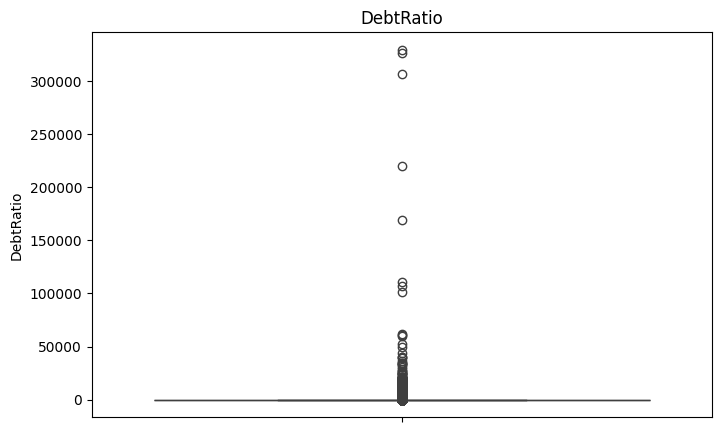

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['DebtRatio'])

plt.title('DebtRatio')

plt.show()

In [18]:
train_df[train_df['MonthlyIncome']>train_df['MonthlyIncome'].quantile(0.75)]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0
12,0,0.010352,46,0,0.298354,12454.0,13,0,2,0,2.0
13,1,0.964673,40,3,0.382965,13700.0,9,3,1,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...
149979,1,0.224711,55,0,0.057235,8700.0,7,0,0,0,0.0
149988,0,0.902051,31,1,0.347924,7515.0,10,0,1,0,0.0
149989,0,0.013356,62,0,0.001408,9233.0,4,0,0,0,3.0
149991,0,0.104112,59,0,0.477658,10316.0,10,0,2,0,0.0


Выборка сильно смещена в сторону маленького месячного дохода и за счет этого даже средний месячный доход становится выбросом

В датасете много выбросов, использую метод межквартильного размаха (IQR) для борьбы с выбросами

In [19]:
def get_rid_of_outliers(df,column_name):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
  return df

In [20]:
columns_names = list(train_df.columns)
for i in columns_names:
  if i == 'SeriousDlqin2yrs':
    continue
  train_df = get_rid_of_outliers(train_df,i)

Полностью избавился от выбросов в возрасте и кооличестве кредитов , и намного улучшилась ситуация с месячным доходом и долговой нагрузкой , месячный доход который попадает в разряд выбросов в данном датасете является адекватным в условиях выдачи кредитов для людей моложе пенсеонного возраста , но поскольку датасет смещён к более старшему поколению , то  распределение данных вполне логично

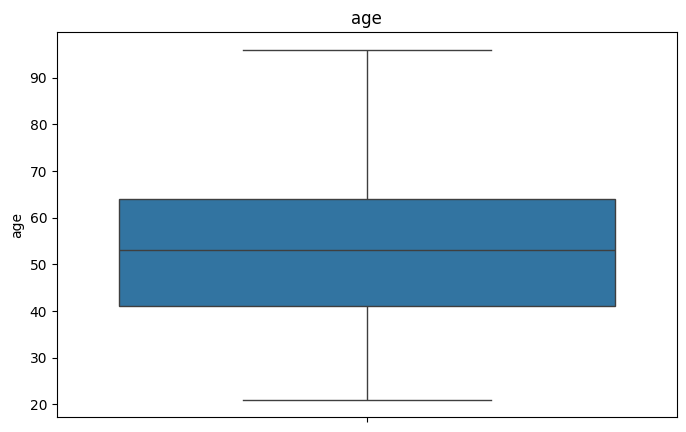

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['age'])

plt.title('age')

plt.show()

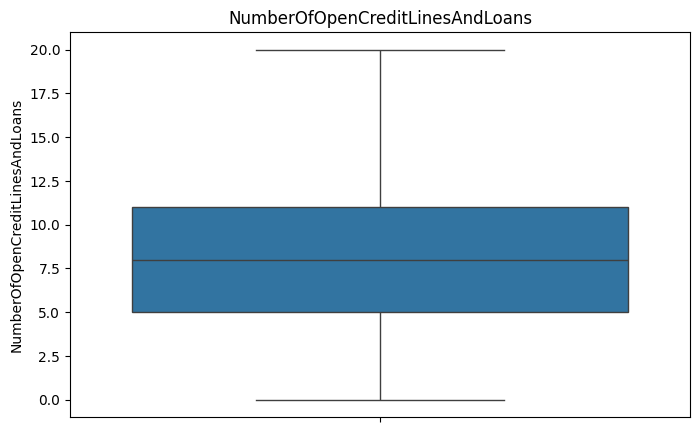

In [22]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['NumberOfOpenCreditLinesAndLoans'])

plt.title('NumberOfOpenCreditLinesAndLoans')

plt.show()

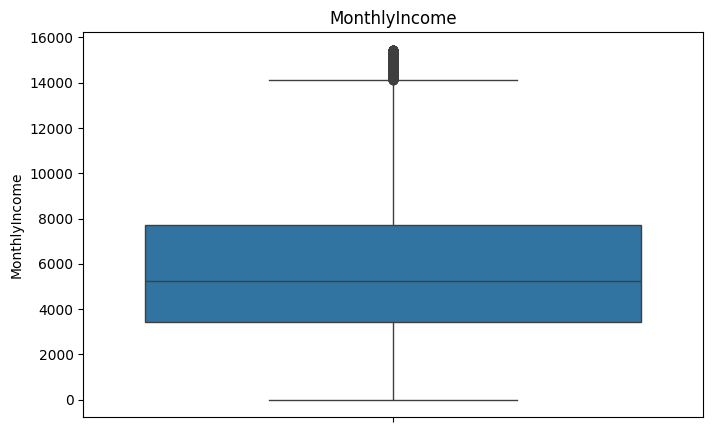

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['MonthlyIncome'])

plt.title('MonthlyIncome')

plt.show()

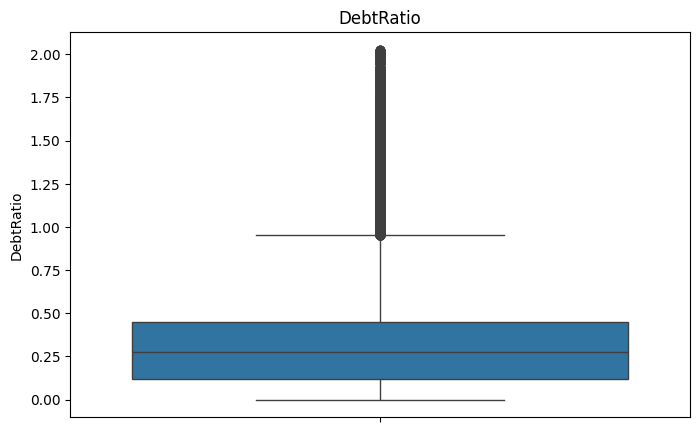

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['DebtRatio'])

plt.title('DebtRatio')

plt.show()

Отделяю целевую пременную , создаю датаесты для будущего сравнения разных возрастных и зарабатных групп

In [25]:
y = train_df['SeriousDlqin2yrs']
X_young = train_df[train_df['age']<35]
X_old = train_df[train_df['age']>35]
X_rich = train_df[train_df['MonthlyIncome']>train_df['MonthlyIncome'].median()]
X_poor = train_df[train_df['MonthlyIncome']<train_df['MonthlyIncome'].median()]
y_young= X_young['SeriousDlqin2yrs']
y_old = X_old['SeriousDlqin2yrs']
y_rich = X_rich['SeriousDlqin2yrs']
y_poor = X_poor['SeriousDlqin2yrs']
X_poor = X_poor.drop('SeriousDlqin2yrs', axis=1)
X_rich = X_rich.drop('SeriousDlqin2yrs', axis=1)
X_old = X_old.drop('SeriousDlqin2yrs', axis=1)
X_young = X_young.drop('SeriousDlqin2yrs', axis=1)
X = train_df.drop('SeriousDlqin2yrs', axis=1)


Стандартизация

In [26]:
scaler = StandardScaler()
X_young = scaler.fit_transform(X_young)
X_old = scaler.fit_transform(X_old)
X_rich = scaler.fit_transform(X_rich)
X_poor = scaler.fit_transform(X_poor)
data_scaler = scaler.fit(X)
X = data_scaler.transform(X)

Анализ дизбаланса классов

In [27]:
y.value_counts()

,count
SeriousDlqin2yrs,
0,76346
1,2209


Видим сильный дизбаланс классов использую SMOTE- оверсемплинг. Не буду использовать даунсемплинг т.к. очень мало людей с дефолтом

In [28]:
oversampler = SMOTE()
X_res,y_res= oversampler.fit_resample(X,y)
X_young_res,y_young_res = oversampler.fit_resample(X_young,y_young)
X_old_res , y_old_res = oversampler.fit_resample(X_old,y_old)
X_rich_res ,y_rich_res = oversampler.fit_resample(X_rich,y_rich)
X_poor_res , y_poor_res = oversampler.fit_resample(X_poor,y_poor)

Проблему с дизбалансом классов решили

In [29]:
y_res.value_counts()

,count
SeriousDlqin2yrs,
0,76346
1,76346


In [30]:
Xtrain, Xtemp, ytrain, ytemp = train_test_split(X_res, y_res, test_size=0.4)
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size=0.5, random_state=42)

2. Построение и оценка модели

Сравню 2 модели : XGBoost и логистическую регрессию , понятное дело , что градиентный бустинг будет лучше , но ради интереса решил сравнить

XGBoost
Обучаю модель , проверяю стабильность с помощью кросс валидации по 5 фолдам , значения метрик беру как среднее с 5 фолдов

In [31]:
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}
bst = XGBClassifier(objective='binary:logistic')

cv_results = cross_validate(
    bst,
    Xtrain,
    ytrain,
    cv=5,
    scoring=scoring
)

Результаты отличные

In [32]:
print(f"Recall: {cv_results['test_roc_auc'].mean()}")
print(f"Precision: {cv_results['test_f1'].mean()}")
print(f"ROC-AUC: {cv_results['test_precision'].mean()}")
print(f"F1-score: {cv_results['test_recall'].mean()}")

Recall: 0.9849406472189092
Precision: 0.9458006259256461
ROC-AUC: 0.9746972109716895
F1-score: 0.9185740382455535


Подберем гиперпараметры: параметров у XGBoost  намного больше , но я не захотел ждать много времени поэтому остановился на : скорости обучения , колличестве деревьев и их глубине

In [33]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': randint(100, 300),
    'learning_rate': [0.01, 0.1, 0.3],
}
model = XGBClassifier(objective='binary:logistic')
random_search = RandomizedSearchCV(model, param_grid, n_iter = 5, cv=5,scoring='roc_auc')
random_search.fit(Xtrain,ytrain)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)
params_XGB =random_search.best_params_

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 125}
Best Cross-Validation Score: 0.9739272831755038


Проверим качество модели с подобранными гиперпараметрами на валидационных данных

In [34]:
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}
bst = XGBClassifier(learning_rate=params_XGB['learning_rate'],max_depth=params_XGB['max_depth'],n_estimators=params_XGB['n_estimators'],objective='binary:logistic')
cv_results = cross_validate(
    bst,
    Xval,
    yval,
    cv=5,
    scoring=scoring
)

Подобранные гиперпараметры показывают хорошее качество на валидационных данных , а значит подобраны правильно

In [35]:
print(f"Recall: {cv_results['test_roc_auc'].mean()}")
print(f"Precision: {cv_results['test_f1'].mean()}")
print(f"ROC-AUC: {cv_results['test_precision'].mean()}")
print(f"F1-score: {cv_results['test_recall'].mean()}")

Recall: 0.969469654686441
Precision: 0.9068493871517264
ROC-AUC: 0.9353503434346273
F1-score: 0.8800522363695723


Посмотрим качество на тесте

In [36]:
bst = XGBClassifier(learning_rate=params_XGB['learning_rate'],max_depth=params_XGB['max_depth'],n_estimators=params_XGB['n_estimators'],objective='binary:logistic')
bst.fit(Xtrain,ytrain)
pred_test = bst.predict(Xtest)

Модель не переобучилась , качество отличное

In [37]:
print(f"Recall: {recall_score(pred_test,ytest)}")
print(f"Precision: {precision_score(pred_test,ytest)}")
print(f"ROC-AUC: {roc_auc_score(pred_test,ytest)}")
print(f"F1-score: {f1_score(pred_test,ytest)}")

Recall: 0.9402744713625543
Precision: 0.8836031056717989
ROC-AUC: 0.9157299034551593
F1-score: 0.9110583446404342


LogisticRegression

Теперь обучим логистическую регрессию по 5 фолдам

In [38]:
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}
Lgr = LogisticRegression()

cv_results = cross_validate(
    Lgr,
    Xtrain,
    ytrain,
    cv=5,
    scoring=scoring
)

Качество даже на трейне намного хуже чем у XGB , модель линейная , скорее всего такое качество связано с нелинейными зависимостями фичей , данные слишком сложны для модельки

In [39]:
print(f"Recall: {cv_results['test_roc_auc'].mean()}")
print(f"Precision: {cv_results['test_f1'].mean()}")
print(f"ROC-AUC: {cv_results['test_precision'].mean()}")
print(f"F1-score: {cv_results['test_recall'].mean()}")

Recall: 0.7629301213950634
Precision: 0.6954183095871272
ROC-AUC: 0.7067266644913868
F1-score: 0.6844847567600402


Подберём гиперпараметры , может быть это улучшит ситуацию

In [40]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['liblinear', 'saga', 'newton-cg'],
}
model = LogisticRegression()
random_search = RandomizedSearchCV(model, param_grid, n_iter = 5, cv=5,scoring='roc_auc')
random_search.fit(Xtrain,ytrain)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)
params =random_search.best_params_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(s

Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1'}
Best Cross-Validation Score: 0.7629303620630971


In [41]:
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}
Lgr = LogisticRegression(penalty=params['penalty'],solver=params['solver'])
cv_results = cross_validate(
    Lgr,
    Xval,
    yval,
    cv=5,
    scoring=scoring
)

Гиперпараметры подобрали хорошо , но весомых изменений в качестве это не дало

In [42]:
print(f"Recall: {cv_results['test_roc_auc'].mean()}")
print(f"Precision: {cv_results['test_f1'].mean()}")
print(f"ROC-AUC: {cv_results['test_precision'].mean()}")
print(f"F1-score: {cv_results['test_recall'].mean()}")

Recall: 0.7600391447385678
Precision: 0.6958512921740339
ROC-AUC: 0.704276483432579
F1-score: 0.6876918054195233


Посмотрим качество на тесте

In [43]:
Lgr = LogisticRegression(penalty=params['penalty'],solver=params['solver'])
Lgr.fit(Xtrain,ytrain)
pred_test = Lgr.predict(Xtest)

Модель не переобучилась , но по сравнению с XGB качество совсем не очень

In [44]:
print(f"Recall: {recall_score(pred_test,ytest)}")
print(f"Precision: {precision_score(pred_test,ytest)}")
print(f"ROC-AUC: {roc_auc_score(pred_test,ytest)}")
print(f"F1-score: {f1_score(pred_test,ytest)}")

Recall: 0.6990420436402341
Precision: 0.691406764047901
ROC-AUC: 0.6982989930589124
F1-score: 0.6952034402911016


В следующем пункте буду рассматривать только XGB с подобранными гиперпараметрами

3. Интерпретация и этика.

Буду использовать SHAP , посмотрим какие фичи для модели оказались наиболее важными

In [45]:
xgb_explainer = shap.Explainer(bst, Xtrain)
xgb_shap_values = xgb_explainer(Xtest)


100%|===================| 30474/30539 [02:49<00:00]       

<ipython-input-46-32765e5750ea>:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(xgb_shap_values,Xtest ,feature_names=feature_names)


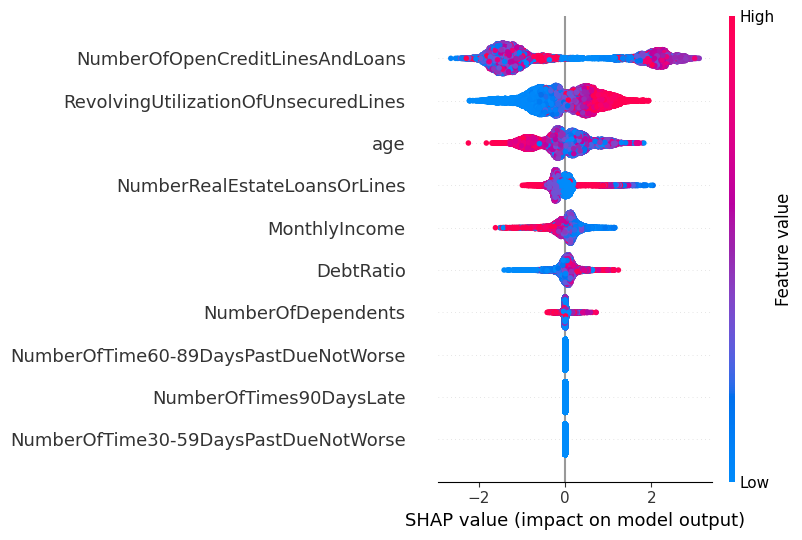

In [46]:
feature_names=[
    'RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse',
    'DebtRatio','MonthlyIncome',	'NumberOfOpenCreditLinesAndLoans',	'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',	'NumberOfTime60-89DaysPastDueNotWorse',	'NumberOfDependents'
]
shap.summary_plot(xgb_shap_values,Xtest ,feature_names=feature_names)

Итак топ 5 признаков модели по важности :


1.   Колличество открытых кредитов - высокие значения этой фичи увеличиваю прогноз модели , а значит чем больше открытых кредитов тем выше риск дефолта , все логично
2.  Коэффициент использования кредита - чем выше процент использования доступных денег на кредитных счетах тем хуже , высокие значения этой перменной увеличивают прогноз модели , все логично
3.   Возраст - чем старше человек тем меньше вероятность дефолта , модель согласна с этим и низкие значения этой фичи(молодые люди) увеличивают прогноз модели , логика сохранена
4.   Число ипотек(кредитов связанных с недвижимостью) - влияние этой переменной боле равномерно , но видно небольшой перекос в сторону того , что низкое колличество ипотек повышает риск дефолта . Это имеет смысл т.к. если человеку одобрили ипотеку , то его доход как минимум средний , а значит что человек без ипотеки с большей вероянтостью дефолтниться
5.   Месячный доход - тут все логичноо : чем больше доход тем меньше прогноз модели


Оценим fairness модели ,  решил сравнить следующие группы :

1.   Люди младше 35 и старше
2.   Люди с доходом ниже медианы и выше



Написал функцию которая считае TPR и FPR

In [47]:
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    TPR = tp / (tp + fn)
    FPR = fp / (fp + tn)
    return TPR, FPR

In [48]:
bst_young = XGBClassifier(learning_rate=params_XGB['learning_rate'],max_depth=params_XGB['max_depth'],n_estimators=params_XGB['n_estimators'],objective='binary:logistic')
bst_young.fit(X_young_res,y_young_res)
preds_test_proba_young = bst_young.predict(X_young_res)
bst_old = XGBClassifier(learning_rate=params_XGB['learning_rate'],max_depth=params_XGB['max_depth'],n_estimators=params_XGB['n_estimators'],objective='binary:logistic')
bst_old.fit(X_old_res,y_old_res)
preds_test_proba_old = bst_old.predict(X_old_res)

Старше 35

In [49]:
calculate_metrics(y_old_res,preds_test_proba_old)

(np.float64(0.9191470938413249), np.float64(0.023255454362717053))

Младше 35

In [51]:
calculate_metrics(y_young_res,preds_test_proba_young)

(np.float64(0.9467842914058053), np.float64(0.010813887307911212))

У людей младше 35 TPR  выше , как мы выяснили чем младше человек тем выше вероятность его дефолта. Модель справедлива

In [52]:
bst_rich = XGBClassifier(learning_rate=params_XGB['learning_rate'],max_depth=params_XGB['max_depth'],n_estimators=params_XGB['n_estimators'],objective='binary:logistic')
bst_rich.fit(X_rich_res,y_rich_res)
preds_test_proba_rich = bst_rich.predict(X_rich_res)
bst_poor = XGBClassifier(learning_rate=params_XGB['learning_rate'],max_depth=params_XGB['max_depth'],n_estimators=params_XGB['n_estimators'],objective='binary:logistic')
bst_poor.fit(X_poor_res,y_poor_res)
preds_test_proba_poor = bst_poor.predict(X_poor_res)

Больше медианы

In [53]:
calculate_metrics(y_rich_res,preds_test_proba_rich)

(np.float64(0.9400563439065108), np.float64(0.01241652754590985))

Меньше медианы

In [54]:
calculate_metrics(y_poor_res,preds_test_proba_poor)

(np.float64(0.9164421908836423), np.float64(0.03950773781228543))

Я ожидал , что TPR будет выше у людей с заработком ниже медианы , но модель посчитала иначе

4. Отчет

Итоги валидации:
1.   Я остановился на модели XGB.Модель отлично справляется с задачей прогназирования дефолта заёмщика.Алгоритм выявляет 94% рискованных заёмщиков с точность 88% ,что критично для минимизации убытков.
Интерпретируемость влияния ключевых факторов:доход , долговая нагрузка , колличество активных кредитов, возраст заёмщика ,соответствует доменным знаниям.

Метрики модели :
*   Recall:94%
*   Precision:88%
*   ROC-AUC:92%
*   F1-score:91%

Ограничения модели:

*   Модель не учитывает социально-экономический контекст

2.   Улучшения:
*   Возрастное смещение приводит к недостаточной репрезентативности для молодых заёмщиков,стоит провести сбор дополнительных данных с меньшим средним возрастом
*   NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents - слишком разреженные и практически не влияют на прогноз модели, необходимо провести сбор дополнительных данных для того чтобы обучить модель эффективно использовать эти фичи
*   Проверка модели на данных из других регионов/временных периодов.

3.   Примеры
*   Если у заёмщика увеличится колличество активных кредитов , то прогноз модели увеличится(вероятность дефолта станет выше)
*   При увеличении месячного дохода прогноз модели уменьшится(вероятность дефолта станет ниже)
*   Коэффициент использования кредита - чем выше тем выше вероятность дефолта



